# Start Point

In [1]:
from IPython.display import display
import IPython
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#!conda install -c anaconda scipy
import scipy as sp
import sklearn as skl
%matplotlib notebook
%matplotlib inline
import tensorflow as tf
import nltk
import mglearn as mglearn
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import re
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import spacy
from tqdm import tqdm

C:\Users\humbe\anaconda3\envs\CVNLP\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\humbe\anaconda3\envs\CVNLP\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\humbe\anaconda3\envs\CVNLP\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\humbe\anaconda3\envs\CVNLP\lib\site-packages\tensorflow\python\f

# 관련 함수

In [2]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives  = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possibles_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    recall = true_positives / (possibles_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives  = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def roc_auc(predictions, target):
    tg, pr, thsld = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(tg, pr)
    return roc_auc

Using TensorFlow backend.


# 전처리 과정 스페인어

In [3]:
def preprocessing(df_x,col):
    df_x[col] = df_x.apply(lambda x: re.sub('[^a-zA-Z]+', ' ', x[col]), axis=1)
    df_x[col] = df_x.apply(lambda x: x[col].lower(),axis=1)
    return df_x

In [4]:
df_1 = pd.read_excel('df_test.xlsx', engine='openpyxl')
df_2 = pd.read_excel('복사본 df_glori(15183).xlsx', engine='openpyxl')
df_2 = df_2[['Unnamed: 1','Comment']]
df_3 = pd.read_excel('finished_df_julio.xlsx', engine='openpyxl')
df_3 = df_3[['Unnamed: 1','Comment']]
df_spanish = pd.concat([df_1,df_2,df_3],axis=0)
df_spanish = df_spanish.dropna()
#df_prepro.to_excel('df_prepro.xlsx')
df_spanish = pd.read_excel('df_prepro.xlsx', engine='openpyxl')

df_spanish['Sentiment'] = df_spanish['Emotion']
df_spanish['Sentiment'] = df_spanish['Sentiment'].map({1:'Negative',2:'Negative',3:'Negative',
                                                     5:'Positive',6:'Positive',7:'Negative',
                                                     4:'Positive',8:'Negative'})

df_spanish['Comment'] = df_spanish['Comment'].astype('str')
df_spanish = preprocessing(df_spanish, 'Comment')

from nltk.corpus import stopwords
stop = stopwords.words('spanish')
df_spanish['tokens'] = df_spanish['Comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

df_spanish.dropna(inplace=True)

df_spanish.drop(df_spanish[df_spanish['tokens'].str.len() <= 5].index.tolist(), inplace=True)
df_spanish.drop('Unnamed: 0', inplace=True, axis=1)
df_spanish.shape

C:\Users\humbe\anaconda3\envs\CVNLP\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


(12746, 4)

In [5]:
df_spanish = df_spanish.rename(columns = {'Comment': 'clean_text', 'Sentiment': 'category'})

In [6]:
df_spanish.columns

Index(['Emotion', 'clean_text', 'category', 'tokens'], dtype='object')

In [7]:
df_spanish[['clean_text', 'category', 'tokens']].iloc[1100:1104]

,clean_text,category,tokens
1104,no creo que este ligado el aumento de femicidi...,Negative,creo ligado aumento femicidios militancia femi...
1105,tengan en consideraci n que agust n laje es to...,Positive,consideraci n agust n laje todav joven quiero ...
1106,estos se ores son dignos de escuchar se aprend...,Positive,ores dignos escuchar aprende
1107,me gustar a ver a este agustin debatir a zizek,Positive,gustar ver agustin debatir zizek


In [8]:
df_spanish.isnull().sum()

Emotion       0
clean_text    0
category      0
tokens        0
dtype: int64

# 전 처리 과정 영어

In [9]:
df_english = pd.read_csv('./english dataset/Twitter_Data.csv')

df_english = df_english.drop(df_english[df_english['category']==0.0].index.tolist())
df_english['category'].value_counts(), len(df_english)

df_positive = df_english[df_english['category']==1].iloc[:10000]
df_negative = df_english[df_english['category']==-1].iloc[:10000]
df_english = pd.concat([df_positive, df_negative], axis=0)

df_english['category'] = df_english['category'].map({1.0:'Positive', -1.0:'Negative'})

from nltk.corpus import stopwords
stop = stopwords.words('english')
df_english['tokens'] = df_english['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

df_english.drop(df_english[df_english['tokens'].str.len() <= 5].index.tolist(), inplace=True)

df_english.shape

(19988, 3)

In [10]:
dummy = pd.get_dummies(df_english['category'], drop_first = True)
df_english = pd.concat([dummy,df_english],axis=1)

In [11]:
df_english[['clean_text', 'category', 'tokens']].head(10)

,clean_text,category,tokens
2,what did just say vote for modi welcome bjp t...,Positive,say vote modi welcome bjp told rahul main camp...
3,asking his supporters prefix chowkidar their n...,Positive,asking supporters prefix chowkidar names modi ...
4,answer who among these the most powerful world...,Positive,answer among powerful world leader today trump...
8,with upcoming election india saga going import...,Positive,upcoming election india saga going important p...
9,gandhi was gay does modi,Positive,gandhi gay modi
10,things like demonetisation gst goods and servi...,Positive,things like demonetisation gst goods services ...
11,hope tuthukudi people would prefer honest well...,Positive,hope tuthukudi people would prefer honest well...
12,calm waters wheres the modi wave,Positive,calm waters wheres modi wave
18,dont play with the words was talking about the...,Positive,dont play words talking modi swamy relation gu...
20,was the one who recently said that people who ...,Positive,one recently said people vote modi anti nation...


In [12]:
df_english['category'].value_counts()

Negative    9997
Positive    9991
Name: category, dtype: int64

# 스페인어 모델 준비

In [13]:
df_s = df_spanish
df_s = df_s.sample(frac=1).reset_index(drop=True)

In [14]:
df_s[['clean_text','category','tokens']].head(15)

,clean_text,category,tokens
0,yo ni dure minutos de video y ya llore soy dem...,Negative,dure minutos video llore demasiado sensible
1,me hico llorar hace a os mi papito se fue de l...,Negative,hico llorar hace papito casa extra hoy cumplea...
2,me alegre al tan solo ver que subiste video li...,Positive,alegre tan solo ver subiste video like si pien...
3,nosotros no fuimos una estrella la biblia dice...,Positive,estrella biblia dice dios form hombre barro polvo
4,titulo esta canci n te pondr feliz de inmediat...,Negative,titulo canci n pondr feliz inmediato despu s e...
5,porfa asme feliz mi mama me odio,Positive,porfa asme feliz mama odio
6,la dra chinda sabe de lo que esta hablando y d...,Negative,dra chinda sabe hablando deja argumentos ignor...
7,la verdad no me genera nada,Negative,verdad genera
8,que br gido el v deo de la ni a lo que m s me ...,Negative,br gido v deo m s llama atenci n nadie ayuda m...
9,el mundo necesita a mas gente como tu cosmo gr...,Positive,mundo necesita mas gente cosmo gracias hacerme...


In [15]:
print('Before Tokenization')
print(df_s.loc[10,'clean_text'])
print(len(df_s.loc[10,'clean_text']))
print()
print('After Tokenization')
print(df_s.loc[10,'tokens'])
print(len(df_s.loc[10,'tokens']))

Before Tokenization
uy me hiciste la vida con este video tp
39

After Tokenization
uy hiciste vida video tp
24


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 2500
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X_spanish = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X_spanish = pad_sequences(X_spanish, padding='post', maxlen=max_len)
    # return sequences
    return X_spanish, tokenizer

print('Before Tokenization & Padding \n', df_s['tokens'][0])
X_spanish, tokenizer = tokenize_pad_sequences(df_s['tokens'])
print('After Tokenization & Padding \n', X_spanish[0])

Before Tokenization & Padding 
 dure minutos video llore demasiado sensible
After Tokenization & Padding 
 [208   5   8 379  76   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [17]:
# Convert categorical variable into dummy/indicator variables.
y_spanish = pd.get_dummies(df_s['category'], drop_first=True)
# Train and Test split
X_train_s, X_test_s,y_train_s, y_test_s = train_test_split(X_spanish, y_spanish, test_size = 0.10, random_state = 42)
#X_valid_s, X_test_s,y_valid_s, y_test_s = train_test_split(X_test_s, y_test_s, test_size = 0.3, random_state = 42)

# Extracting validation set from the train set
#valid_size=1000
#X_valid_s, y_valid_s = X_train_s[-valid_size:], y_train_s[-valid_size:]
#X_test_s, y_test_s = X_train_s[:-valid_size], y_train_s[:-valid_size]

#print('Train Set ->', X_train_s.shape, y_train_s.shape)
#print('Validation Set ->', X_valid_s.shape, y_valid_s.shape)
#print('Test Set ->', X_test_s.shape, y_test_s.shape)

In [18]:
X_train_s.shape

(11471, 50)

In [23]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Dropout

vocab_size = 5000
embedding_size = 32

# Build model
model1 = Sequential()

model1.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))

model1.add(LSTM(64))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))

model1.add(Dense(1, activation='sigmoid'))

print(model1.summary())

# Compile model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision_m, recall_m])


# Train model
num_epochs = 20
batch_size = 32

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 32)            160000    
_________________________________________________________________
batch_normalization_3 (Batch (None, 50, 32)            128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 32)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                24832     
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total para

In [20]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 32)            160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 168,353
Trainable params: 168,353
Non-trainable params: 0
_________________________________________________________________


In [68]:
#model1.fit(X_train_s, y_train_s, validation_data=(X_valid_s, y_valid_s),batch_size=batch_size, epochs=num_epochs, verbose=1)
model1.fit(X_train_s, y_train_s, validation_split=0.05, batch_size=batch_size, epochs=num_epochs, verbose=1)

Train on 10292 samples, validate on 542 samples
Epoch 1/20
10292/10292 [==============================] - 287s 28ms/step - loss: 0.7757 - acc: 0.5371 - val_loss: 0.7820 - val_acc: 0.3506
Epoch 2/20
10292/10292 [==============================] - 287s 28ms/step - loss: 0.6017 - acc: 0.6815 - val_loss: 0.6125 - val_acc: 0.6808
Epoch 3/20
10292/10292 [==============================] - 295s 29ms/step - loss: 0.5325 - acc: 0.7312 - val_loss: 0.5795 - val_acc: 0.6956
Epoch 4/20
10292/10292 [==============================] - 306s 30ms/step - loss: 0.5215 - acc: 0.7447 - val_loss: 0.5804 - val_acc: 0.7159
Epoch 5/20
10292/10292 [==============================] - 307s 30ms/step - loss: 0.4700 - acc: 0.7740 - val_loss: 0.6105 - val_acc: 0.7122
Epoch 6/20
10292/10292 [==============================] - 305s 30ms/step - loss: 0.4357 - acc: 0.7954 - val_loss: 0.5432 - val_acc: 0.7232
Epoch 7/20
10292/10292 [==============================] - 297s 29ms/step - loss: 0.4093 - acc: 0.8056 - val_loss: 0.51

In [69]:
df_history = pd.DataFrame(model1.history.history)

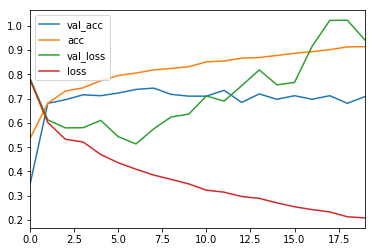

In [70]:
df_history[['val_acc', 'acc', 'val_loss', 'loss']].plot()

Text(0.5,1,'LSTM Model Performance Results for Spanish')

<Figure size 432x288 with 0 Axes>

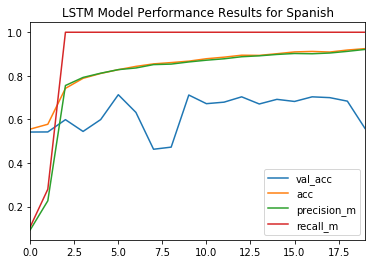

In [41]:
plt.figure()
df_history[['val_acc', 'acc',
       'precision_m', 'recall_m']].plot()
plt.title('LSTM Model Performance Results for Spanish')

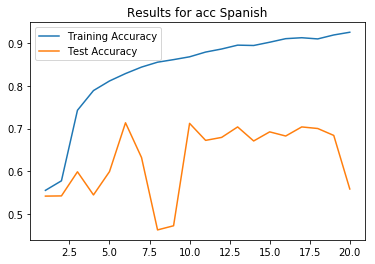

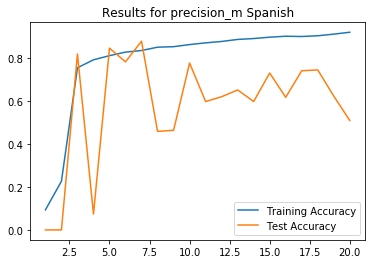

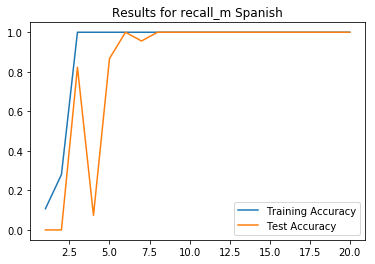

In [42]:
for i in ['acc', 'precision_m', 'recall_m']:
    acc = model1.history.history[i]
    val_acc = model1.history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)
    
    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Test Accuracy')
    plt.title('Results for {} Spanish'.format(i))
    plt.legend()
    plt.show()

# 영어 모델 준비

In [16]:
df_e = df_english

In [17]:
df_e.head(10)

,Positive,clean_text,category,tokens
2,1,what did just say vote for modi welcome bjp t...,Positive,say vote modi welcome bjp told rahul main camp...
3,1,asking his supporters prefix chowkidar their n...,Positive,asking supporters prefix chowkidar names modi ...
4,1,answer who among these the most powerful world...,Positive,answer among powerful world leader today trump...
8,1,with upcoming election india saga going import...,Positive,upcoming election india saga going important p...
9,1,gandhi was gay does modi,Positive,gandhi gay modi
10,1,things like demonetisation gst goods and servi...,Positive,things like demonetisation gst goods services ...
11,1,hope tuthukudi people would prefer honest well...,Positive,hope tuthukudi people would prefer honest well...
12,1,calm waters wheres the modi wave,Positive,calm waters wheres modi wave
18,1,dont play with the words was talking about the...,Positive,dont play words talking modi swamy relation gu...
20,1,was the one who recently said that people who ...,Positive,one recently said people vote modi anti nation...


In [20]:
from sklearn.model_selection import train_test_split

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X_english = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X_english = pad_sequences(X_english, padding='post', maxlen=max_len)
    # return sequences
    return X_english, tokenizer

print('Before Tokenization & Padding \n', df_e['clean_text'][0])
X_english, tokenizer = tokenize_pad_sequences(df_e['clean_text'])
print('After Tokenization & Padding \n', X_english[0])

Before Tokenization & Padding 
 when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
After Tokenization & Padding 
 [  25   66   40  100   36    4    1 1222   20  500    5   37    2  509
 3075    4    1   97    1   61   40 4032    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [22]:
# Convert categorical variable into dummy/indicator variables.
y_english = pd.get_dummies(df_e['category'], drop_first=True)
# Train and Test split
X_train_e, X_test_e,y_train_e, y_test_e = train_test_split(X_english, y_english, test_size = 0.3, random_state = 42)
# Extracting validation set from the train set
valid_size=1000
X_valid_e, y_valid_e = X_train_e[-valid_size:], y_train_e[-valid_size:]
X_test_e, y_test_e = X_train_e[:-valid_size], y_train_e[:-valid_size]

print('Train Set ->', X_train_e.shape, y_train_e.shape)
print('Validation Set ->', X_valid_e.shape, y_valid_e.shape)
print('Test Set ->', X_test_e.shape, y_test_e.shape)

Train Set -> (13991, 50) (13991, 1)
Validation Set -> (1000, 50) (1000, 1)
Test Set -> (12991, 50) (12991, 1)


In [23]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

vocab_size = 5000
embedding_size = 32

# Build model
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model1.add(LSTM(32))
model1.add(Dropout(0.4))
model1.add(Dense(1, activation='sigmoid'))

print(model1.summary())

# Compile model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision_m, recall_m])


# Train model
num_epochs = 20
batch_size = 32

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 32)            160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 168,353
Trainable params: 168,353
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
model1.fit(X_train_e, y_train_e, validation_data=(X_valid_e, y_valid_e),batch_size=batch_size, epochs=num_epochs, verbose=1)

Train on 13991 samples, validate on 1000 samples
Epoch 1/20
13991/13991 [==============================] - 17s 1ms/step - loss: 0.6934 - acc: 0.4993 - precision_m: 0.4714 - recall_m: 0.8971 - val_loss: 0.6935 - val_acc: 0.4820 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/20
13991/13991 [==============================] - 16s 1ms/step - loss: 0.6934 - acc: 0.4976 - precision_m: 0.4544 - recall_m: 0.8353 - val_loss: 0.6930 - val_acc: 0.5180 - val_precision_m: 0.5180 - val_recall_m: 1.0000
Epoch 3/20
13991/13991 [==============================] - 16s 1ms/step - loss: 0.6892 - acc: 0.5213 - precision_m: 0.4754 - recall_m: 0.8513 - val_loss: 0.6837 - val_acc: 0.5460 - val_precision_m: 0.5332 - val_recall_m: 1.0000
Epoch 4/20
13991/13991 [==============================] - 16s 1ms/step - loss: 0.6472 - acc: 0.6396 - precision_m: 0.7026 - recall_m: 0.9954 - val_loss: 0.6181 - val_acc: 0.6940 - val_precision_m: 0.6592 - val_recall_m: 1.0000
Epoch 5/20
13991/13991 [===========

In [37]:
df_history = pd.DataFrame(model1.history.history)

Text(0.5,1,'LSTM Model Performance Results for English')

<Figure size 432x288 with 0 Axes>

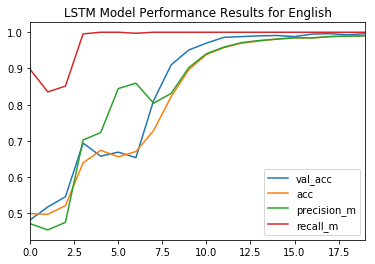

In [45]:
plt.figure()
df_history[['val_acc', 'acc',
       'precision_m', 'recall_m']].plot()
plt.title('LSTM Model Performance Results for English')

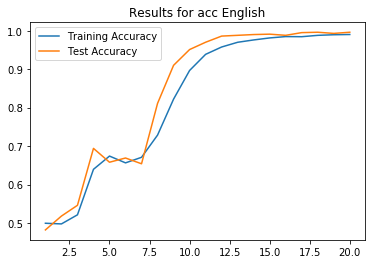

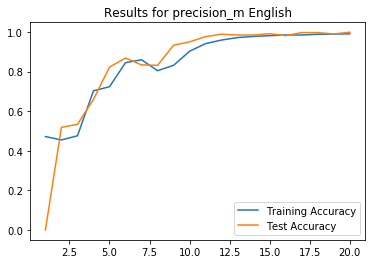

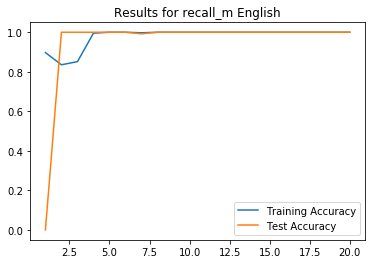

In [25]:
for i in ['acc', 'precision_m', 'recall_m']:
    acc = model1.history.history[i]
    val_acc = model1.history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)
    
    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Test Accuracy')
    plt.title('Results for {} English'.format(i))
    plt.legend()
    plt.show()

# 다른 모델 분석 스페인어

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train_s, y_train_s)
rfc_pred = rfc.predict(X_test_s)
print(confusion_matrix(y_test_s, rfc_pred))
print('\n')
print(classification_report(y_test_s,rfc_pred))

C:\Users\humbe\anaconda3\envs\CVNLP\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\humbe\anaconda3\envs\CVNLP\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


[[4421   16]
 [  33 3452]]


             precision    recall  f1-score   support

          0       0.99      1.00      0.99      4437
          1       1.00      0.99      0.99      3485

avg / total       0.99      0.99      0.99      7922



In [28]:
from sklearn.svm import SVC
model_svc = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

model_svc.fit(X_train_s, y_train_s)
svc_pred = model_svc.predict(X_test_s)
print(confusion_matrix(y_test_s, svc_pred))
print('\n')
print(classification_report(y_test_s,svc_pred))

C:\Users\humbe\anaconda3\envs\CVNLP\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[4401   36]
 [  53 3432]]


             precision    recall  f1-score   support

          0       0.99      0.99      0.99      4437
          1       0.99      0.98      0.99      3485

avg / total       0.99      0.99      0.99      7922



In [29]:
from sklearn.naive_bayes import GaussianNB 

gnb = GaussianNB()
gnb.fit(X_train_s, y_train_s)
gnb_pred = rfc.predict(X_test_s)
print(confusion_matrix(y_test_s, gnb_pred))
print('\n')
print(classification_report(y_test_s,gnb_pred))

[[4421   16]
 [  33 3452]]


             precision    recall  f1-score   support

          0       0.99      1.00      0.99      4437
          1       1.00      0.99      0.99      3485

avg / total       0.99      0.99      0.99      7922



In [30]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc.fit(X_train_s, y_train_s)
gbc_pred = rfc.predict(X_test_s)
print(confusion_matrix(y_test_s, gbc_pred))
print('\n')
print(classification_report(y_test_s,gbc_pred))

[[4421   16]
 [  33 3452]]


             precision    recall  f1-score   support

          0       0.99      1.00      0.99      4437
          1       1.00      0.99      0.99      3485

avg / total       0.99      0.99      0.99      7922



# 다른 모델 분석 영어

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

In [32]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train_e, y_train_e)
rfc_pred = rfc.predict(X_test_e)
print(confusion_matrix(y_test_e, rfc_pred))
print('\n')
print(classification_report(y_test_e,rfc_pred))

C:\Users\humbe\anaconda3\envs\CVNLP\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


[[6537    0]
 [   0 6454]]


             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6537
          1       1.00      1.00      1.00      6454

avg / total       1.00      1.00      1.00     12991



In [33]:
from sklearn.svm import SVC
model_svc = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

model_svc.fit(X_train_e, y_train_e)
svc_pred = model_svc.predict(X_test_e)
print(confusion_matrix(y_test_e, svc_pred))
print('\n')
print(classification_report(y_test_e,svc_pred))

C:\Users\humbe\anaconda3\envs\CVNLP\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[6537    0]
 [   0 6454]]


             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6537
          1       1.00      1.00      1.00      6454

avg / total       1.00      1.00      1.00     12991



In [34]:
from sklearn.naive_bayes import GaussianNB 

gnb = GaussianNB()
gnb.fit(X_train_e, y_train_e)
gnb_pred = rfc.predict(X_test_e)
print(confusion_matrix(y_test_e, gnb_pred))
print('\n')
print(classification_report(y_test_e,gnb_pred))

[[6537    0]
 [   0 6454]]


             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6537
          1       1.00      1.00      1.00      6454

avg / total       1.00      1.00      1.00     12991



In [35]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc.fit(X_train_e, y_train_e)
gbc_pred = rfc.predict(X_test_e)
print(confusion_matrix(y_test_e, gbc_pred))
print('\n')
print(classification_report(y_test_e,gbc_pred))

[[6537    0]
 [   0 6454]]


             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6537
          1       1.00      1.00      1.00      6454

avg / total       1.00      1.00      1.00     12991

